## Project
    - Retrival Augmented Generation (RAG)
    - Build Chatbot
    
- document loading: 80 unique loades LangChain provides
- Document splitting: best practices in document splitting
- Vector stores and embeddings: vector store integrations with LangChain
- Retrival: accessing and indexing data in vector store
- Question Answering: 
- Chat: chatbot using LangChain

## LangChain
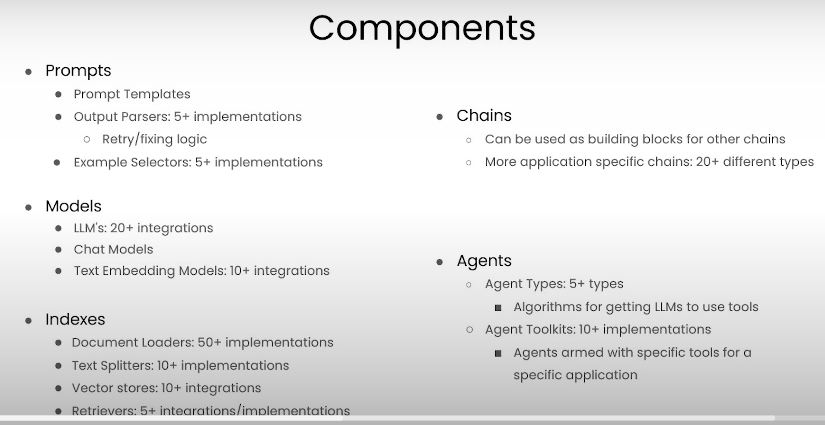

- How to load data
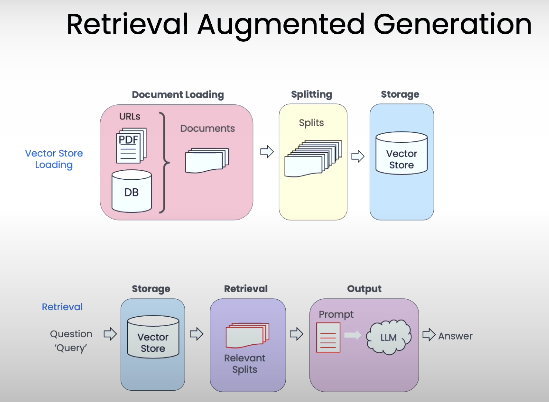
- document -> splitting document -> storing in vector databases
- symanic search
- memory: fully functional data

## 1. Document loading
- 80 document loders
    - Accessing and converting data
    - from websites, databases, youtube, pdf, html, json, word, etc
    - return a list of document objects
    
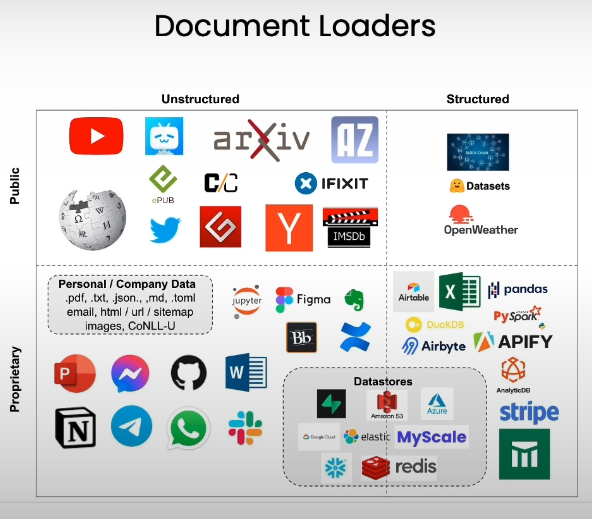

In [ ]:

from langchain.document_loaders import PyPDFLoader

loader = PyPDFLoader('doc_path')
pages = loader.load()

# load the list of documents
len(pages) #prints the number of pages

page = pages[0]
print(page.page_content[:500])

page.metadata # to access the metadata of the page

## 2. Document Splitting
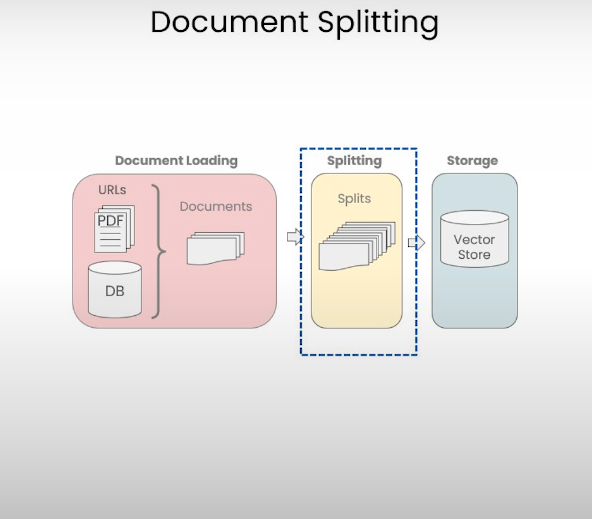
- the context window is limitted (specific number of tokens)
- we need to send only the relevant docs to the model

- splitting
    - chunk size
    - chunk overlap: shares in 2 chunks

### Methods
- create_documnet(): create documents from a list of text
- split_documents(): splits documents


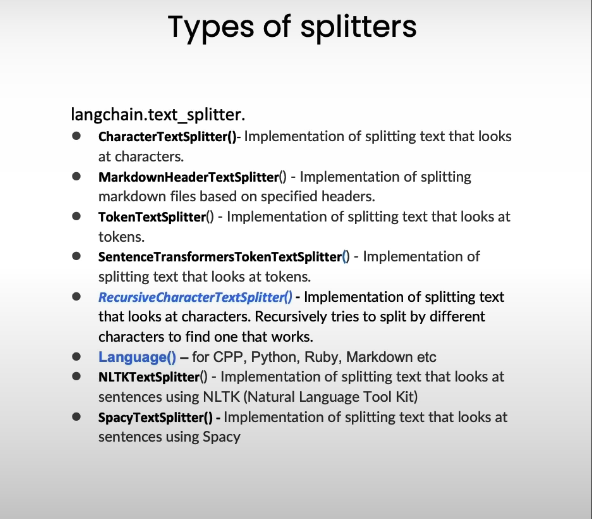

In [ ]:
import os
import openai
import sys

openai.aip_key = os.environ['OPEN_API_KEY']

from langchain.text_splitter import RecursiveCharacterTextSplitter

r_splitter = RecursiveCharacterTextSplitter(
    chunk_size=26,
    chunk_overlap=4,
    seperators=['\n\n', '\n', '(?<=\. )', ' ', ''] # optional argument
)
# (?<=\.) a look behind regex
text = 'some text'

r_splitter.split_text(text)

### Token Text splitter
- often LLMs has restriction of context window on number of tokens

In [ ]:
from langchain.text_splitter import TokenSplitter

t_splitter(
    chunk_size = 10
    chunk_overlap = 0
    
)

text = 'some text'

t_splitter.split_text(text)
docs = t_splitter.split_documents(text) # return documents
    # Source and Meta-data included with the doucments

## 3. Vector Store & Embeddings
- index the split doc, to retrieve them to answer the questions

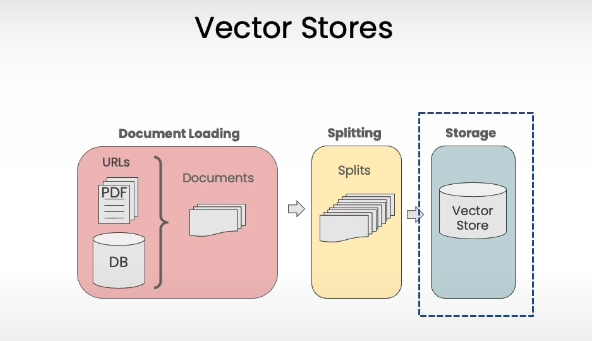

- Building chatbots

- reson for embeddings
    - embedding vectors captures meaning
    - similar text has similar vectors
    - can find similar vectors

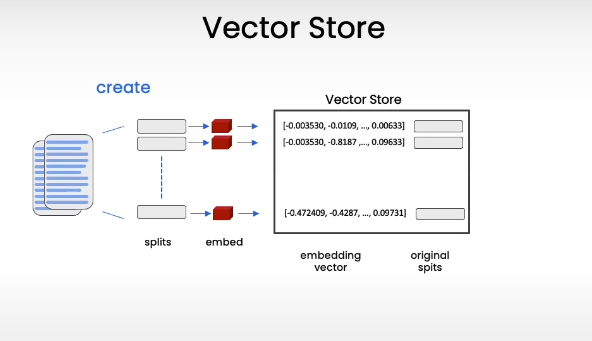

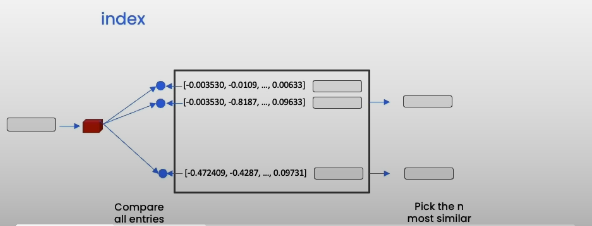

- pass the similar vectors to LLMs to give context

In [ ]:
from langchain.embeddings.openai import OpenAIEmbeddings
embeddings = OpenAIEmbeddings()

sentence1 = 'sentence 1'
sentence2 = 'sentence 2'
sentence3 = 'sentence 3'

embeddings1 = embeddings.embed_query(sentence1)

# push the data into vector store
from langchain.vectorstores import Chroma

persist_directory = 'docs/chroma'

vectordb = Chroma.from_documents(
    documents = splits,
    embeddings = embedding,
    persist_directory = persist_directory
)

print(vectordb._collection.count())

question = 'is there an email i can ask for help'

docs =  vectordb.similarity_search(question, k=3)

vectordb.persist()
# to use the data for future use
# need to explore more

## 4. Retrieval
- symantic search
- edge cases
    - information in the metadata
    
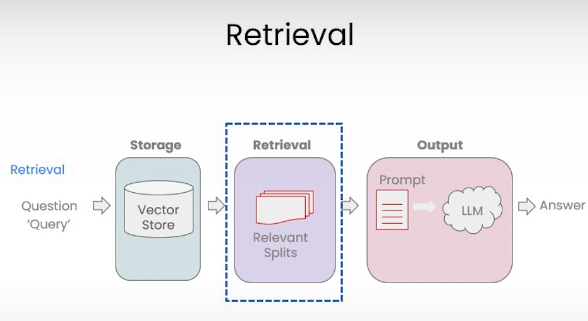

- need to retrieve the most relevent splits
- Maximum marginal relevance (MMR)
    - retrieve the most similar responce
    - k value, that takes a number of splits
- LLM aided retrieval
    - convert the question into a query
    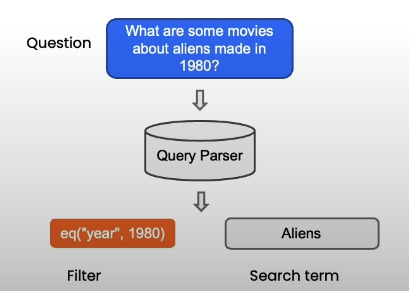
    - can use a Language Model to convert the query
- Compression
    - the retrived segements can be compressed by a language model to get the compressed relevant splits



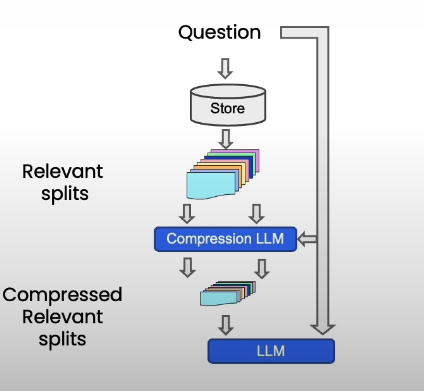

In [ ]:
import os
import openai
import sys

openai.api_key = os.environ['OPENAI_API_KEY']


from langchain.vectorstoeres import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

persist_directory = 'docs/chroma/'

embeddings = OpenAIEmbeddings()

vectordb = Chroma(
    persist_directory=persist_directory,
    embedding_function=embedding
)

print(vectordb._collection.count())

## 5. Question Answering
- question answering -> prompt { question + relevant splits

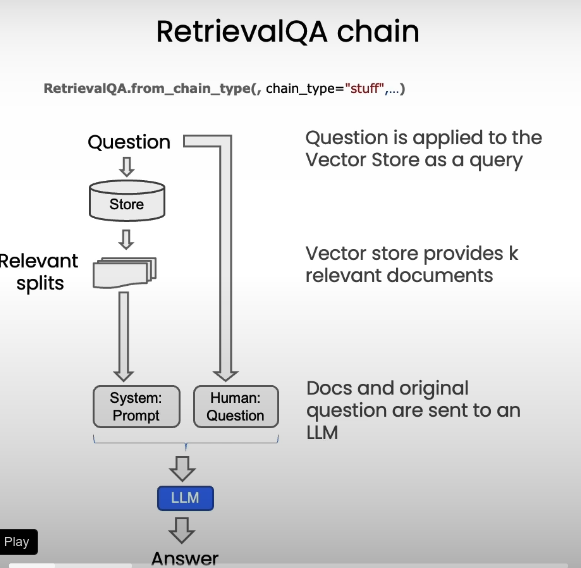

- all chunks passed to same context window
- however additional methods are available
    - map reduce
    - refine
    - map rerank
    - some time there are many documents and we can't pass all the documents to the context window in a single go
    

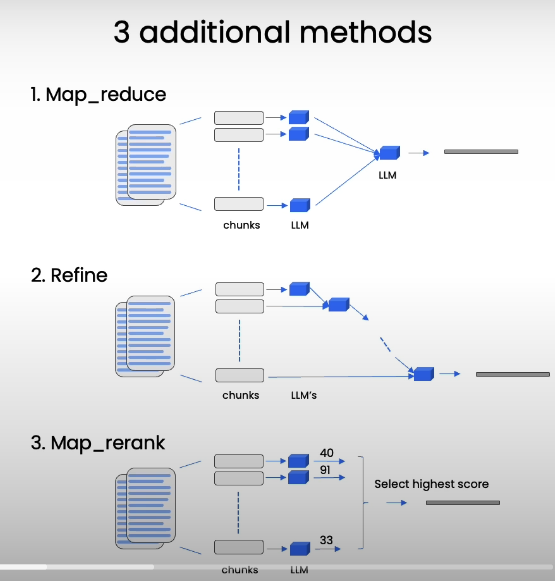

In [ ]:
from langchain.vectorstrores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

persist_directory = 'docs/chroma'

embeddings = OpenAIEmbeddings()

vectordb = Chroma(
    persist_directory = persist_directory,
    embedding_function = embeddings
)

# check the content
print(vectordb._collection.count())

# similarity search
question = 'what are major topics for this class?'
docs = vectordb.similarity_search(question, k=3)

# now need to initialize the language model to answer the question
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(
    model_name='gpt-3.5-turbo', temperature=0
) # temperature=0 ensure the factual answers, variability set to 0

# for question answering
from langchain.chains import RetrievalQA

# not explicitly created the prompt to the model
qa_chain = RetrievalQA.from_chain_type(
    llm, retriever=vectordb.as_retriver()
)

result = qa_chain({'query': question})

result['result']

### Map Reduce

In [ ]:
qa_chain = RetrievalQA.from_chain_type(
    llm, 
    retriever=vectordb.as_retriver(),
    chain_type='map_reduce'
)

# many call to the language model for retrieval

# chain_type = 'refine' : a new chain type

## 6. Chat
- the chains we are using till now is not retaining the previous context
- so a follow-up question will not be aswered correctly
- to ask a follow-up question, we need to introduce memory into the system

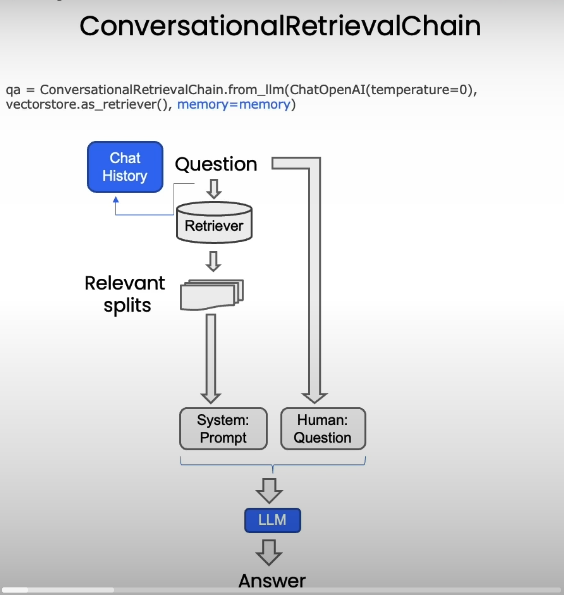

- need to add the answer with the chat history
- may need to add additiaonl retriver and compression features as needed


In [ ]:
from langchain.vectorstrores import Chroma
from langchain.embeddings.openai import OpenAIEmbeddings

persist_directory = 'docs/chroma'

embeddings = OpenAIEmbeddings()

vectordb = Chroma(
    persist_directory = persist_directory,
    embedding_function = embeddings
)

# check the content
print(vectordb._collection.count())

# similarity search
question = 'what are major topics for this class?'
docs = vectordb.similarity_search(question, k=3)

# now need to initialize the language model to answer the question
from langchain.chat_models import ChatOpenAI
llm = ChatOpenAI(
    model_name='gpt-3.5-turbo', temperature=0
) # temperature=0 ensure the factual answers, variability set to 0

# for question answering
from langchain.chains import RetrievalQA

# not explicitly created the prompt to the model
qa_chain = RetrievalQA.from_chain_type(
    llm, retriever=vectordb.as_retriver()
)

result = qa_chain({'query': question})
result['result']

# adding memory to the QA
from langchain.memory import ConversationBufferMemory
memory = ConversationBufferMemory(
    momory_key='chat_history',
    return_messages=True
)
# keep a history of past messages
# pass it with the question to llm

In [ ]:
from langchain.chains import ConversationalRetrivalChain

retriever = vectordb.as_retriver()

qa = ConversationalRetrivalChain(
    llm,
    retriever=retriever,
    memory=memory
)

question = 'Is probability a class topic?'
result = qa({'question': question})

result['answer']

In [ ]:
question = 'why are those prerequesites needed?'
result = qa({'question': question})